In [2]:
from astroquery.gaia import Gaia

query = """
SELECT
    source_id, ra, dec,
    parallax, pmra, pmdec,
    phot_g_mean_mag, bp_rp, ruwe
FROM gaiadr3.gaia_source
WHERE
    CONTAINS(
        POINT('ICRS', ra, dec),
        CIRCLE('ICRS', 0.5, 67.4, 0.8)
    ) = 1
    AND parallax > 0
    AND parallax_over_error > 5
    AND ruwe < 1.4
    AND phot_g_mean_mag < 19
"""

job = Gaia.launch_job_async(query)
df = job.get_results().to_pandas()

print(len(df))
df.to_csv("berk59_gaia.csv", index=False)

Workaround solutions for the Gaia Archive issues following the infrastructure upgrade: https://www.cosmos.esa.int/web/gaia/news#WorkaroundArchive
INFO: Query finished. [astroquery.utils.tap.core]
8991


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('berk59_gaia.csv')
print(len(df), 'Gaia sources loaded')

8991 Gaia sources loaded


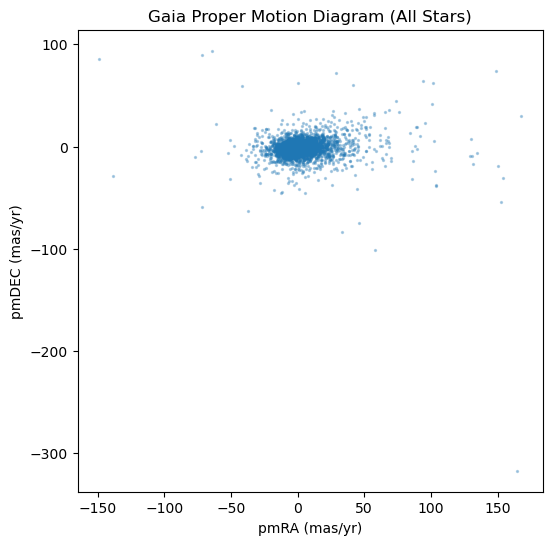

In [6]:
plt.figure(figsize=(6,6))
plt.scatter(df.pmra, df.pmdec, s=2, alpha=0.3)
plt.xlabel('pmRA (mas/yr)')
plt.ylabel('pmDEC (mas/yr)')
plt.title('Gaia Proper Motion Diagram (All Stars)')
plt.show()

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

In [8]:
X = df[['parallax', 'pmra', 'pmdec']].values
X_scaled = StandardScaler().fit_transform(X)

In [9]:
db = DBSCAN(eps=0.5, min_samples=10)
labels = db.fit_predict(X_scaled)

In [10]:
df['cluster'] = labels

In [11]:
main_cluster = df['cluster'].value_counts().idxmax()
members = df[df.cluster == main_cluster]

In [12]:
print('Cluster members:', len(members))

Cluster members: 8476


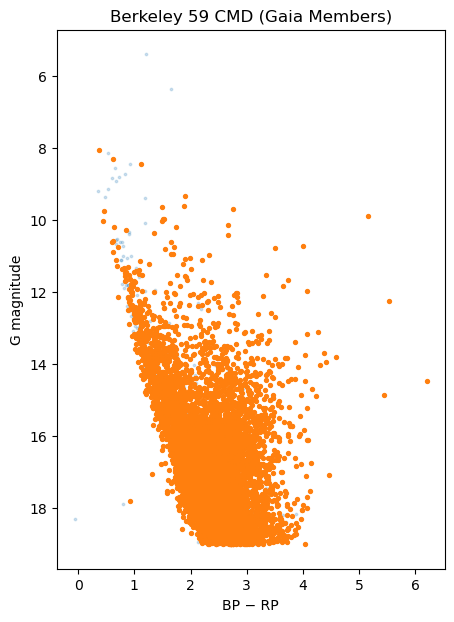

In [13]:
plt.figure(figsize=(5,7))
plt.scatter(df.bp_rp, df.phot_g_mean_mag, s=3, alpha=0.2)
plt.scatter(members.bp_rp, members.phot_g_mean_mag, s=8)
plt.gca().invert_yaxis()
plt.xlabel('BP − RP')
plt.ylabel('G magnitude')
plt.title('Berkeley 59 CMD (Gaia Members)')
plt.show()

In [19]:
from astropy.io import fits
bands = ['g','r','i']
images = {}
for b in bands:
    images[b] = fits.open(f'Berk_{b}.wcs.proc.fits')[0].data

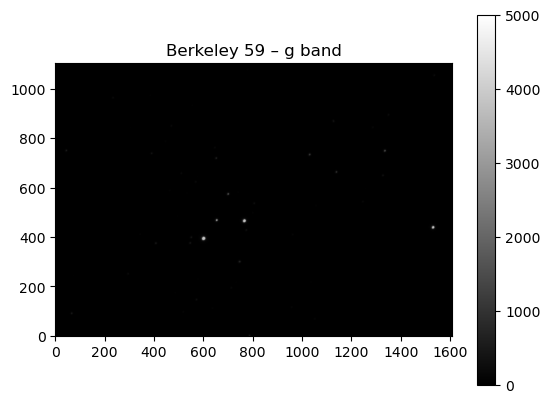

In [20]:
plt.imshow(images['g'], origin='lower', cmap='gray', vmin=0, vmax=5000)
plt.title('Berkeley 59 – g band')
plt.colorbar()
plt.show()

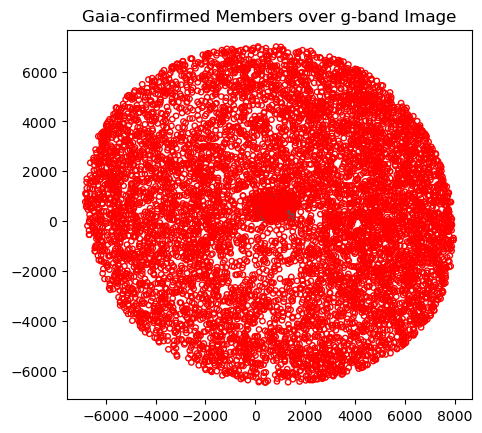

In [22]:
from astropy.wcs import WCS
hdr = fits.open('Berk_g.wcs.proc.fits')[0].header
wcs = WCS(hdr)
xpix, ypix = wcs.world_to_pixel_values(members.ra, members.dec)
plt.imshow(images['g'], origin='lower', cmap='gray')
plt.scatter(xpix, ypix, s=15, edgecolor='red', facecolor='none')
plt.title('Gaia-confirmed Members over g-band Image')
plt.show()